<a href="https://colab.research.google.com/github/PranavRathod399/Blacklace/blob/main/code/simulations/%5BV-4%5Dgraph-amp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
class GrapheneAmplifier:
    """Simulation of graphene-based EEG signal amplifier for Blacklace BCI"""

    def __init__(self, conductivity=1e-8, electron_mobility=1e5,
                 thickness_nm=25, area_mm2=10):
        """
        Initialize graphene amplifier with material properties

        Parameters:
        - conductivity: in-plane resistivity (Ω·m)
        - electron_mobility: (cm²/V·s)
        - thickness_nm: thickness in nanometers
        - area_mm2: electrode area in mm²
        """
        # Validate parameters
        if thickness_nm <= 0 or area_mm2 <= 0:
            raise ValueError("Thickness and area must be positive values")

        self.conductivity = conductivity
        self.electron_mobility = electron_mobility
        self.thickness_nm = thickness_nm
        self.area_mm2 = area_mm2

        # Calculated properties
        self.contact_impedance = self._calculate_impedance()
        self.noise_floor = self._calculate_noise_floor()

    def _calculate_impedance(self, freq=10):
        """
        Calculate electrode-skin impedance based on material properties

        Parameters:
        - freq: frequency in Hz for impedance calculation

        Returns:
        - Impedance in ohms
        """
        # Enhanced model with frequency dependence
        base_impedance = 10000  # Typical skin impedance in ohms
        graphene_factor = 0.1 * (self.thickness_nm / 25) * (10 / self.area_mm2)
        # Simple frequency dependence model
        capacitive_factor = 1 / (1 + 0.01 * freq)
        return base_impedance * graphene_factor * capacitive_factor

    def _calculate_noise_floor(self):
        """Calculate thermal noise floor using Johnson-Nyquist noise equation"""
        k_boltzmann = 1.38e-23  # Boltzmann constant
        temp_kelvin = 310  # Body temperature
        bandwidth = 100  # Hz, typical EEG bandwidth
        return np.sqrt(4 * k_boltzmann * temp_kelvin * self.contact_impedance * bandwidth)

    def amplify_signal(self, eeg_signal, gain=1000, cutoff=40, fs=500):
        """
        Amplify EEG signal using graphene amplifier model

        Parameters:
        - eeg_signal: input EEG signal in microvolts
        - gain: amplification factor
        - cutoff: lowpass filter cutoff frequency in Hz
        - fs: sampling frequency in Hz

        Returns:
        - amplified_signal: output signal with noise model
        """
        # Add realistic noise based on properties
        noise = np.random.normal(0, self.noise_floor, len(eeg_signal))

        # Model non-linear response (simplified)
        amplified = gain * eeg_signal

        # Apply frequency response characteristics (lowpass filtering)
        b, a = signal.butter(4, cutoff/(fs/2), 'low')
        filtered = signal.filtfilt(b, a, amplified + noise)

        return filtered

    def plot_frequency_response(self, fs=500, cutoff=40):
        """
        Plot the frequency response of the amplifier

        Parameters:
        - fs: sampling frequency in Hz
        - cutoff: filter cutoff frequency in Hz
        """
        b, a = signal.butter(4, cutoff/(fs/2), 'low')
        w, h = signal.freqz(b, a)

        plt.figure(figsize=(10, 6))
        plt.plot(w * fs / (2 * np.pi), 20 * np.log10(abs(h)))
        plt.title('Blacklace Graphene Amplifier Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain (dB)')
        plt.grid(True)
        plt.xlim(0, 100)
        plt.show()

    def simulate_eeg_acquisition(self, duration_sec=10, fs=500, include_bands=None):
        """
        Simulate acquisition of EEG signal through graphene amplifier

        Parameters:
        - duration_sec: recording duration in seconds
        - fs: sampling frequency in Hz
        - include_bands: dictionary of frequency bands to include with their parameters

        Returns:
        - raw_signal: simulated raw EEG
        - amplified_signal: signal after graphene amplification
        """
        t = np.arange(0, duration_sec, 1/fs)

        # Default bands to include if none specified
        if include_bands is None:
            include_bands = {
                'alpha': {'freq': 10, 'amp': 15},  # 8-12 Hz
                'beta': {'freq': 20, 'amp': 5},    # 13-30 Hz
                'theta': {'freq': 6, 'amp': 10},   # 4-7 Hz
                'delta': {'freq': 2, 'amp': 20}    # 0.5-4 Hz
            }

        # Generate combined signal from all frequency bands
        raw_eeg = np.zeros_like(t)
        for band_name, params in include_bands.items():
            # Add some natural variation to the frequency
            freq_variation = np.random.normal(1, 0.05)
            raw_eeg += params['amp'] * np.sin(2 * np.pi * params['freq'] * freq_variation * t)

        # Add background EEG activity (1/f noise)
        n_samples = len(t)
        background = np.random.randn(n_samples)
        # Create 1/f noise by filtering white noise
        for i in range(1, n_samples):
            background[i] = 0.95 * background[i-1] + 0.15 * np.random.randn()

        # Scale background to realistic EEG amplitude (~5-10 μV)
        background = background * 5

        # Add optional motion artifacts
        if duration_sec > 3:  # Add artifact in longer recordings
            # Simple motion artifact model (high amplitude transient)
            artifact_time = int(duration_sec * 0.7 * fs)  # At 70% of recording
            artifact_duration = int(0.2 * fs)  # 200ms duration
            artifact = np.zeros_like(raw_eeg)
            artifact[artifact_time:artifact_time+artifact_duration] = 50 * np.sin(
                2 * np.pi * 3 * np.arange(artifact_duration) / fs
            )
            # Add exponential decay
            decay = np.exp(-np.arange(artifact_duration)/20)
            artifact[artifact_time:artifact_time+artifact_duration] *= decay
        else:
            artifact = np.zeros_like(raw_eeg)

        # Combine all signal components
        raw_eeg = raw_eeg + background + artifact

        # Apply graphene amplifier
        amplified = self.amplify_signal(raw_eeg)

        return raw_eeg, amplified

    def compare_materials(self, other_materials=None):
        """
        Compare graphene with other electrode materials

        Parameters:
        - other_materials: dict of material names and their impedance values

        Returns:
        - Comparative visualization and dict of results
        """
        if other_materials is None:
            other_materials = {
                'Ag/AgCl': 5000,  # Standard medical electrode
                'Gold': 7500,
                'Stainless Steel': 15000,
                'Dry Electrode': 50000,
                'Carbon Nanotube': 3000  # Added CNT for comparison
            }

        # Add graphene to comparison
        materials = {**other_materials, 'Graphene': self.contact_impedance}

        # Calculate theoretical SNR for each material
        # SNR ∝ 1/√impedance
        snrs = {}
        for material, imp in materials.items():
            noise = np.sqrt(4 * 1.38e-23 * 310 * imp * 100)
            signal = 15e-6  # 15 μV typical EEG
            snrs[material] = 20 * np.log10(signal / noise)

        # Calculate relative power consumption (simplified model)
        power = {}
        for material, imp in materials.items():
            # Power ∝ V²/R for signal transmission
            power[material] = 100 * 5000 / imp  # Normalized to Ag/AgCl = 100

        # Create bar chart
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 3, 1)
        plt.bar(materials.keys(), materials.values(), color=['silver', 'gold', 'gray', 'brown', 'black', 'green'])
        plt.title('Electrode-Skin Impedance by Material')
        plt.ylabel('Impedance (Ω)')
        plt.yscale('log')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha='right')

        plt.subplot(1, 3, 2)
        plt.bar(snrs.keys(), snrs.values(), color=['silver', 'gold', 'gray', 'brown', 'black', 'green'])
        plt.title('Theoretical Signal-to-Noise Ratio')
        plt.ylabel('SNR (dB)')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha='right')

        plt.subplot(1, 3, 3)
        plt.bar(power.keys(), power.values(), color=['silver', 'gold', 'gray', 'brown', 'black', 'green'])
        plt.title('Relative Power Consumption')
        plt.ylabel('Power (normalized)')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        return {
            'impedances': materials,
            'snrs': snrs,
            'power': power
        }

    def analyze_signal_quality(self, eeg_signal, fs=500):
        """
        Analyze the quality of an EEG signal

        Parameters:
        - eeg_signal: input EEG signal to analyze
        - fs: sampling frequency in Hz

        Returns:
        - quality metrics dictionary
        """
        # Calculate power spectral density
        f, pxx = signal.welch(eeg_signal, fs, nperseg=fs)

        # Calculate SNR for different frequency bands
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }

        band_powers = {}
        for band_name, (low, high) in bands.items():
            band_mask = (f >= low) & (f <= high)
            band_powers[band_name] = np.mean(pxx[band_mask]) if np.any(band_mask) else 0

        # Calculate overall SNR (assuming signal in alpha band, noise in others)
        signal_power = band_powers['alpha']
        noise_bands = [b for b in band_powers.keys() if b != 'alpha']
        noise_power = np.mean([band_powers[b] for b in noise_bands])
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else 0

        # Calculate signal quality metrics
        # Root Mean Square (RMS) amplitude
        rms = np.sqrt(np.mean(eeg_signal**2))

        # Peak-to-peak amplitude
        p2p = np.max(eeg_signal) - np.min(eeg_signal)

        # Plot PSD with frequency bands highlighted
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(eeg_signal))/fs, eeg_signal)
        plt.title('EEG Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (μV)')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.semilogy(f, pxx)
        colors = ['b', 'g', 'r', 'c', 'm']
        for (band_name, (low, high)), color in zip(bands.items(), colors):
            band_mask = (f >= low) & (f <= high)
            plt.fill_between(f[band_mask], pxx[band_mask], alpha=0.3, color=color)

        plt.title(f'Power Spectral Density (SNR: {snr:.2f} dB)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD (μV²/Hz)')
        plt.xlim(0, 50)
        plt.legend(['PSD'] + list(bands.keys()))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Return comprehensive metrics
        metrics = {
            'SNR': snr,
            'RMS': rms,
            'Peak-to-Peak': p2p,
            'Band Powers': band_powers
        }

        return metrics

    def optimize_parameters(self, parameter_ranges=None, test_duration=2):
        """
        Optimize amplifier parameters for best SNR

        Parameters:
        - parameter_ranges: dict of parameter names and their ranges to test
        - test_duration: duration of test signal in seconds

        Returns:
        - Optimal parameter values and results dictionary
        """
        if parameter_ranges is None:
            parameter_ranges = {
                'thickness_nm': [5, 10, 25, 50, 100],
                'area_mm2': [5, 10, 15, 20, 30]
            }

        results = {}
        best_snr = -float('inf')
        best_params = {}

        # Generate synthetic EEG for testing
        t = np.arange(0, test_duration, 1/500)

        # Create more realistic test signal with multiple frequency components
        test_eeg = (
            15 * np.sin(2 * np.pi * 10 * t) +  # Alpha
            5 * np.sin(2 * np.pi * 20 * t) +   # Beta
            10 * np.sin(2 * np.pi * 6 * t)     # Theta
        )
        # Add noise
        noise = np.random.randn(len(t)) * 5
        test_eeg += noise

        # Create results grid for heatmap
        thickness_values = parameter_ranges['thickness_nm']
        area_values = parameter_ranges['area_mm2']
        snr_grid = np.zeros((len(thickness_values), len(area_values)))

        # Try different parameter combinations
        for i, thickness in enumerate(thickness_values):
            for j, area in enumerate(area_values):
                # Create amplifier with these parameters
                amp = GrapheneAmplifier(thickness_nm=thickness, area_mm2=area)

                # Amplify signal
                amplified = amp.amplify_signal(test_eeg)

                # Calculate SNR
                f, pxx = signal.welch(amplified, 500, nperseg=500)
                alpha_mask = (f >= 8) & (f <= 13)
                other_mask = ~alpha_mask & (f <= 50)
                signal_power = np.mean(pxx[alpha_mask])
                noise_power = np.mean(pxx[other_mask])
                snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else 0

                # Store in grid for heatmap
                snr_grid[i, j] = snr

                # Store result
                param_key = f"Thickness {thickness}nm, Area {area}mm²"
                results[param_key] = snr

                # Track best parameters
                if snr > best_snr:
                    best_snr = snr
                    best_params = {'thickness_nm': thickness, 'area_mm2': area}

        # Visualize results with heatmap and bar chart
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)
        plt.imshow(snr_grid, cmap='viridis', aspect='auto', origin='lower')
        plt.colorbar(label='SNR (dB)')
        plt.xticks(np.arange(len(area_values)), area_values)
        plt.yticks(np.arange(len(thickness_values)), thickness_values)
        plt.xlabel('Area (mm²)')
        plt.ylabel('Thickness (nm)')
        plt.title('SNR by Parameter Combination')

        plt.subplot(1, 2, 2)
        plt.bar(results.keys(), results.values())
        plt.title('SNR by Parameter Combination')
        plt.ylabel('SNR (dB)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

        plt.tight_layout()
        plt.show()

        return best_params, results

    def simulate_temperature_effect(self, temp_range=(20, 40), steps=5):
        """
        Simulate the effect of temperature on amplifier performance

        Parameters:
        - temp_range: (min_temp, max_temp) in Celsius
        - steps: number of temperature points to simulate

        Returns:
        - Dictionary of results at different temperatures
        """
        temperatures = np.linspace(temp_range[0], temp_range[1], steps)
        results = {}

        # Generate test signal
        t = np.arange(0, 2, 1/500)
        test_signal = 15 * np.sin(2 * np.pi * 10 * t)  # Simple sine wave

        plt.figure(figsize=(12, 6))

        for temp_c in temperatures:
            # Convert to Kelvin
            temp_k = temp_c + 273.15

            # Recalculate noise floor for this temperature
            k_boltzmann = 1.38e-23
            bandwidth = 100  # Hz
            noise_floor = np.sqrt(4 * k_boltzmann * temp_k * self.contact_impedance * bandwidth)

            # Generate noise for this temperature
            noise = np.random.normal(0, noise_floor, len(test_signal))

            # Apply amplification
            amplified = 1000 * test_signal

            # Add temperature-dependent noise
            output = amplified + noise

            # Calculate SNR
            signal_power = np.mean(amplified**2)
            noise_power = np.mean(noise**2)
            snr = 10 * np.log10(signal_power / noise_power)

            # Store results
            results[f"{temp_c:.1f}°C"] = {
                'noise_floor': noise_floor,
                'snr': snr
            }

            # Plot output signal for this temperature
            plt.plot(t, output, label=f"{temp_c:.1f}°C")

        plt.title('Temperature Effect on Amplifier Output')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (μV)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot temperature vs SNR
        plt.figure(figsize=(10, 6))
        plt.plot(list(results.keys()), [r['snr'] for r in results.values()], 'o-')
        plt.title('Temperature vs Signal-to-Noise Ratio')
        plt.xlabel('Temperature')
        plt.ylabel('SNR (dB)')
        plt.grid(True)
        plt.show()

        return results

Blacklace Graphene Amplifier Simulation
---------------------------------------
Electrode-Skin Impedance: 909.09 Ω
Theoretical Noise Floor: 0.0394 μV


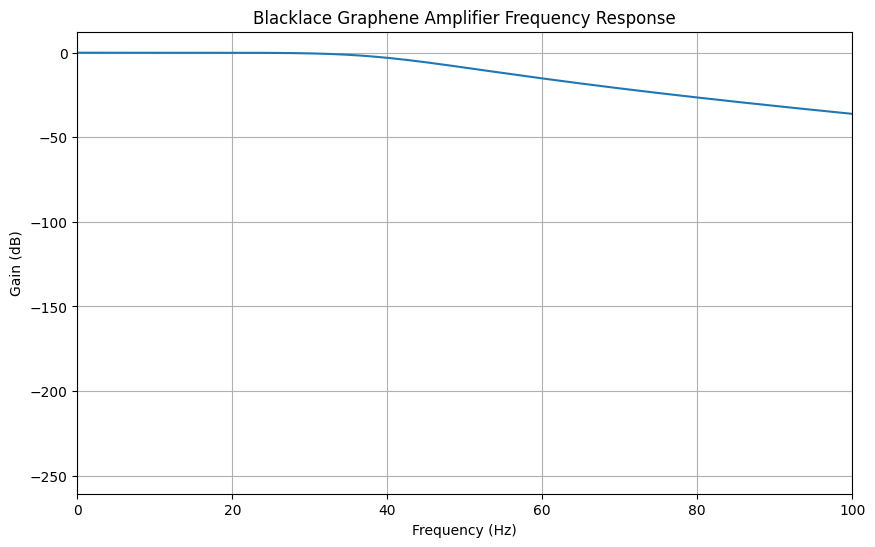

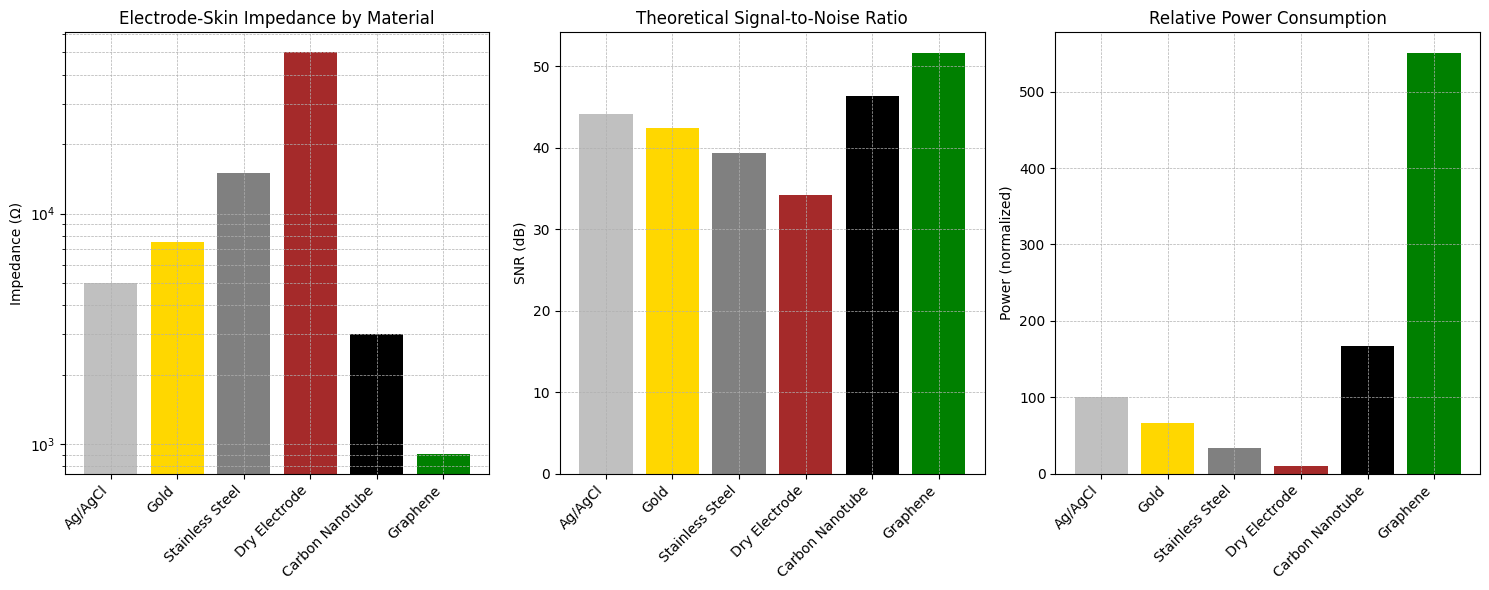


Material Comparison:
  Ag/AgCl: 5000.0 Ω, SNR: 44.20 dB
  Gold: 7500.0 Ω, SNR: 42.44 dB
  Stainless Steel: 15000.0 Ω, SNR: 39.43 dB
  Dry Electrode: 50000.0 Ω, SNR: 34.20 dB
  Carbon Nanotube: 3000.0 Ω, SNR: 46.42 dB
  Graphene: 909.1 Ω, SNR: 51.60 dB

Simulating EEG acquisition...


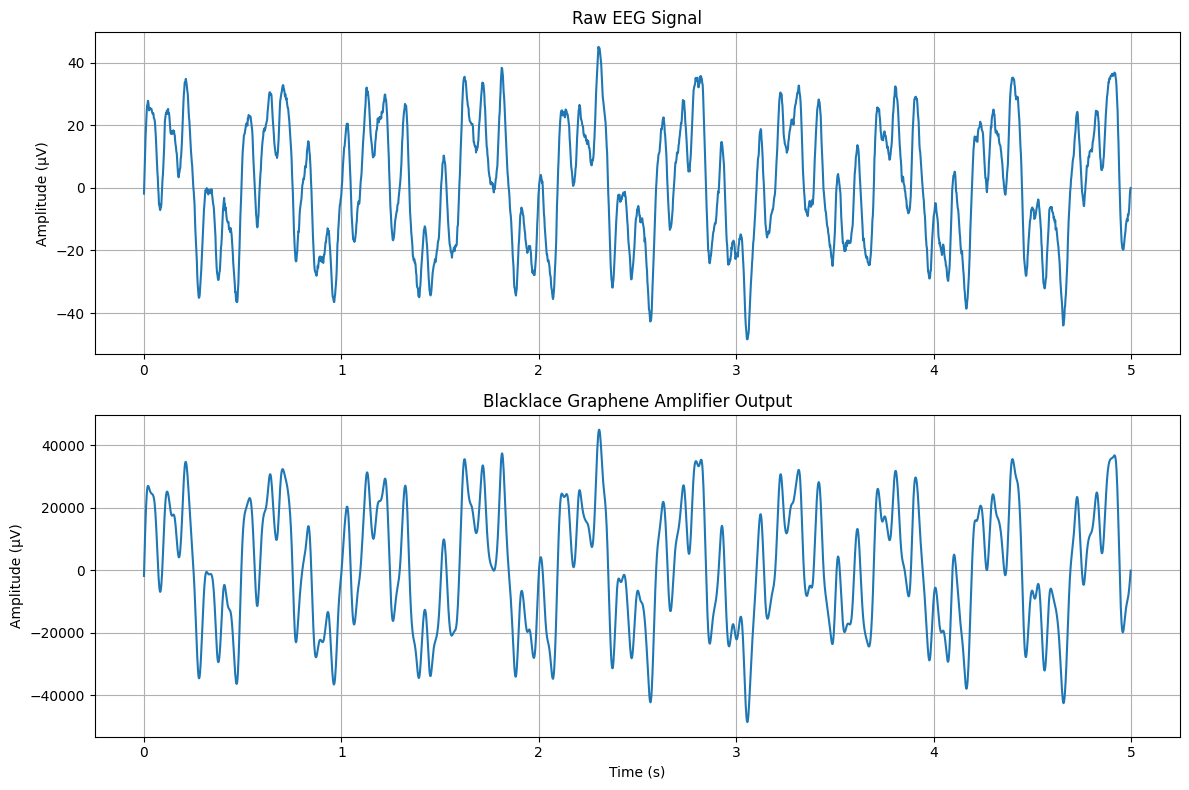


Analyzing Signal Quality...


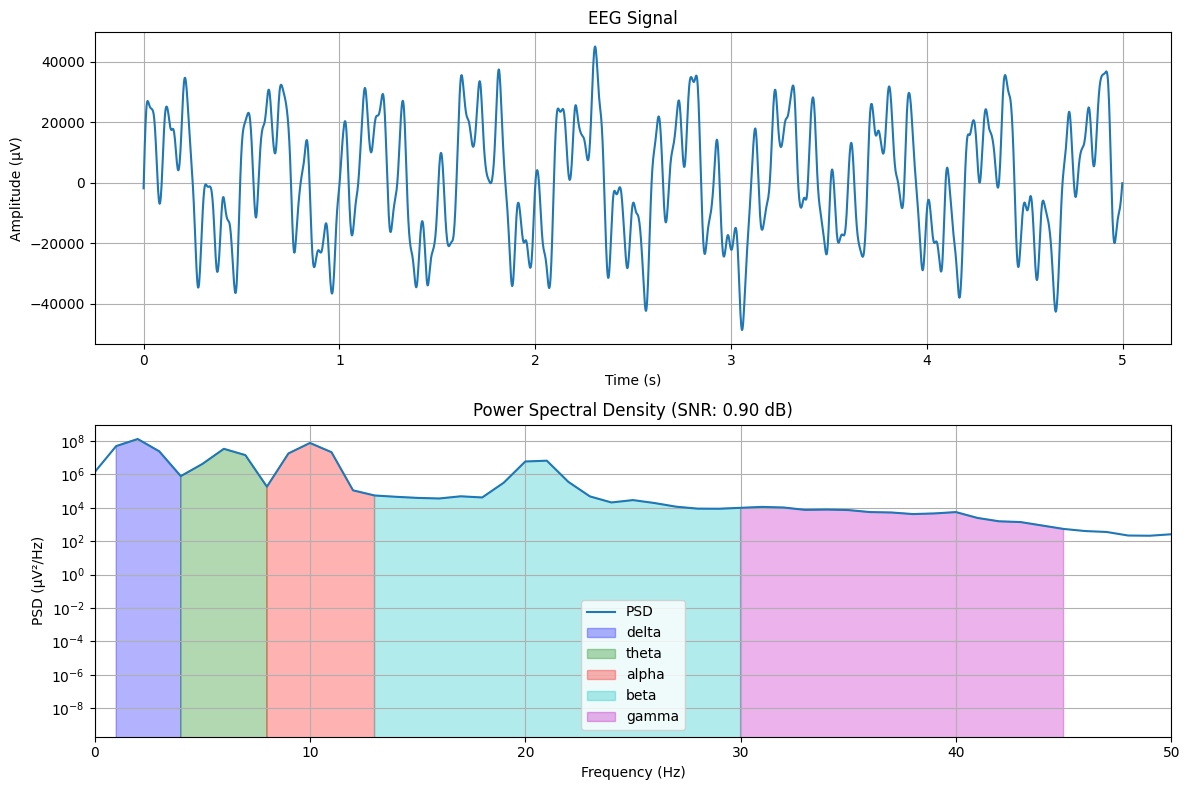

Signal-to-Noise Ratio: 0.90 dB
RMS Amplitude: 19594.61 μV
Peak-to-Peak Amplitude: 93587.82 μV
Frequency Band Powers:
  delta: 51115467.71 μV²/Hz
  theta: 10621547.28 μV²/Hz
  alpha: 19200168.28 μV²/Hz
  beta: 753648.46 μV²/Hz
  gamma: 5380.03 μV²/Hz

Optimizing Amplifier Parameters...


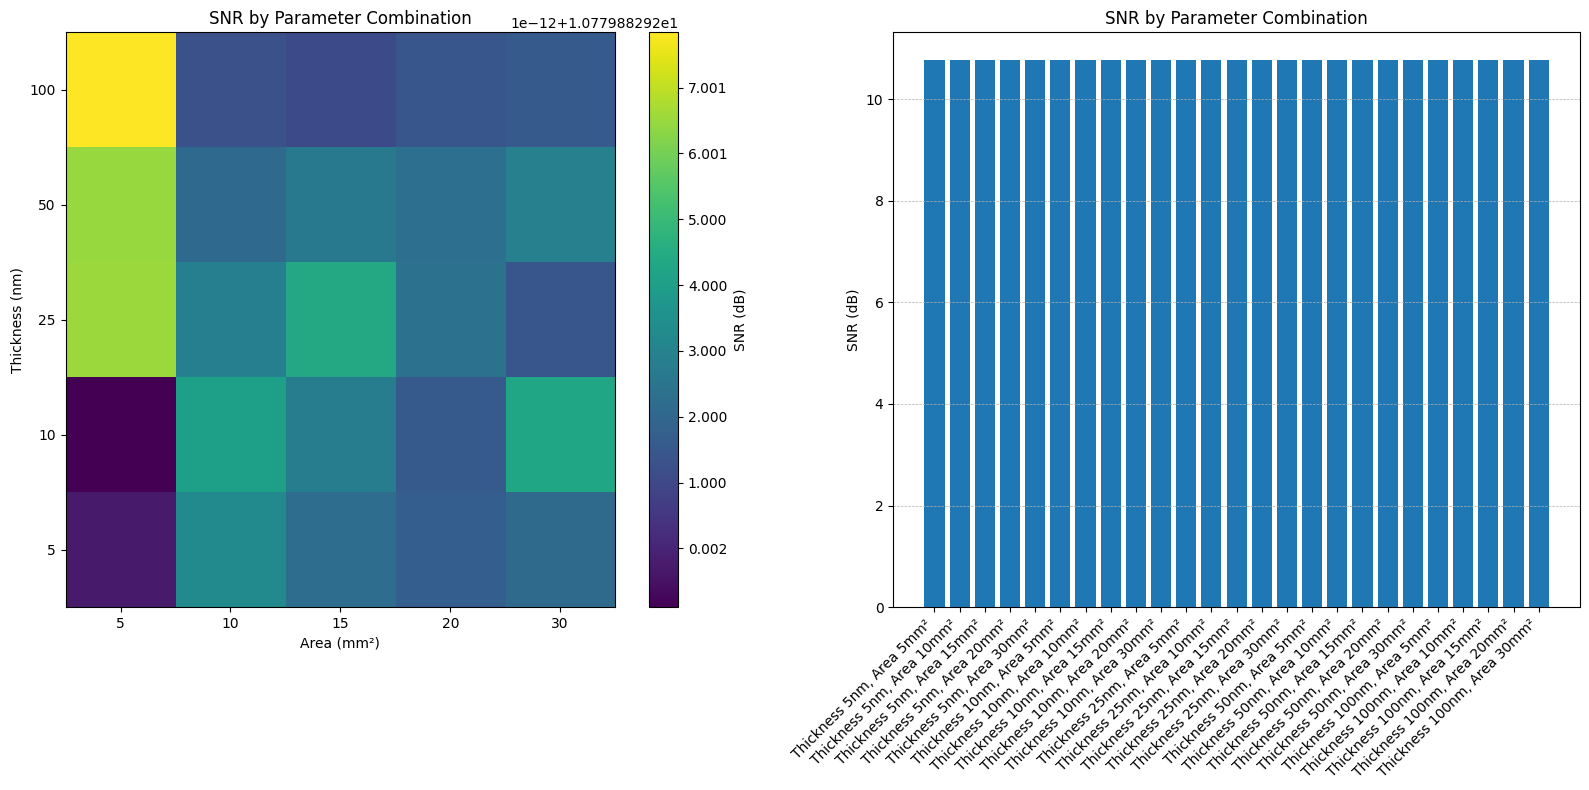

Optimal Parameters: Thickness = 100 nm, Area = 5 mm²

Creating Optimized Amplifier...


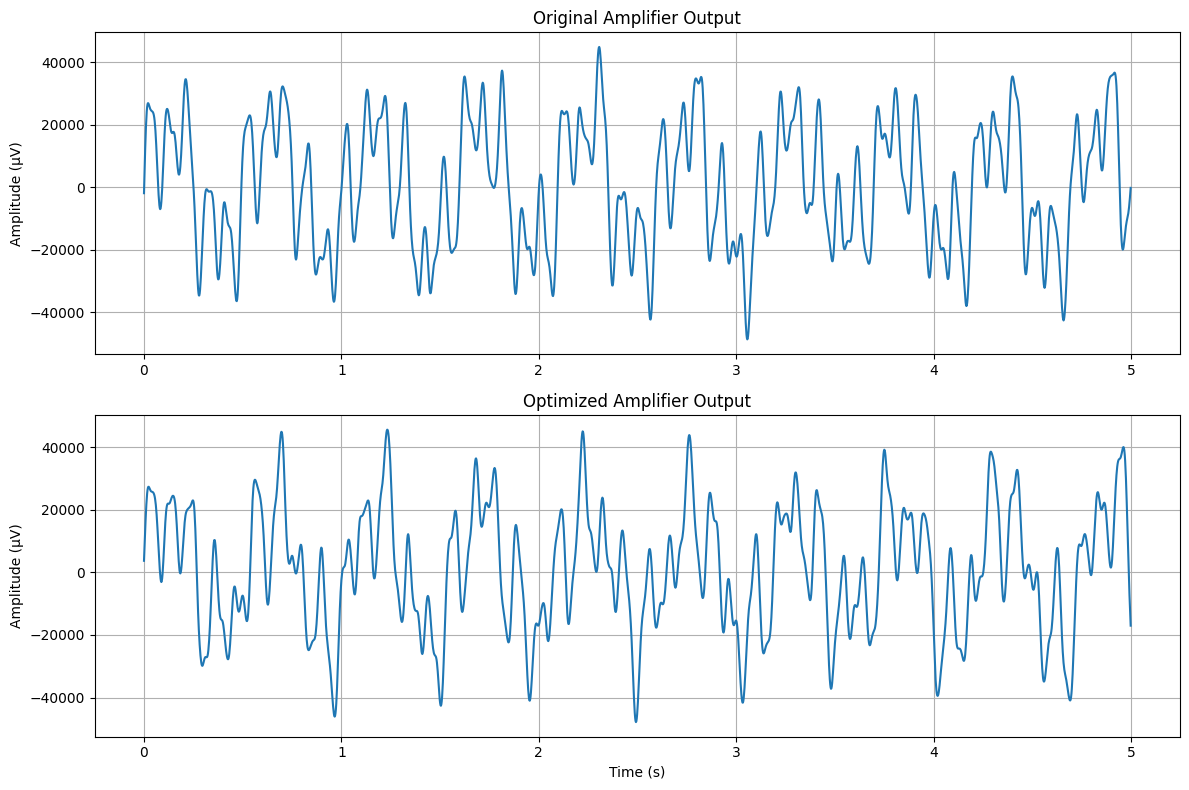


Simulating Temperature Effects...


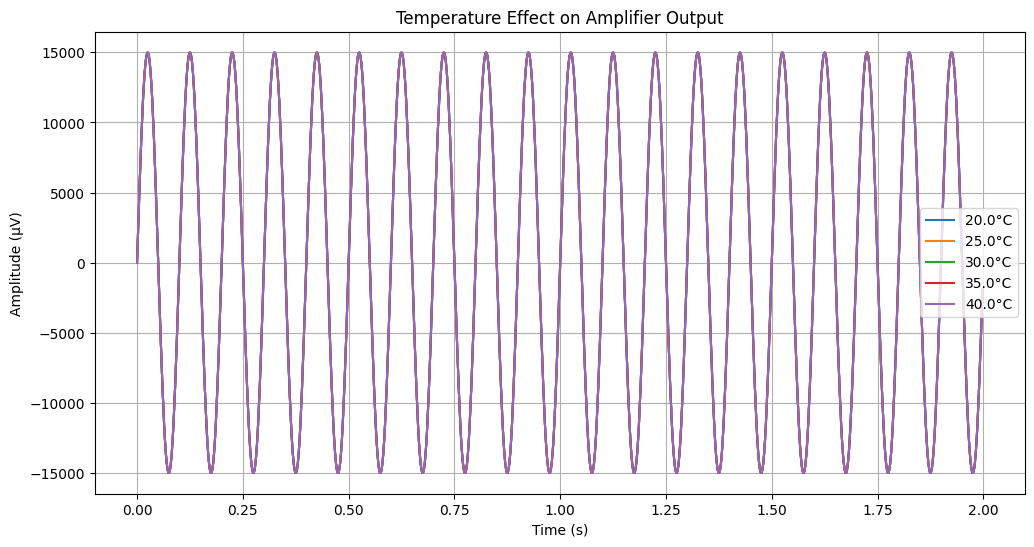

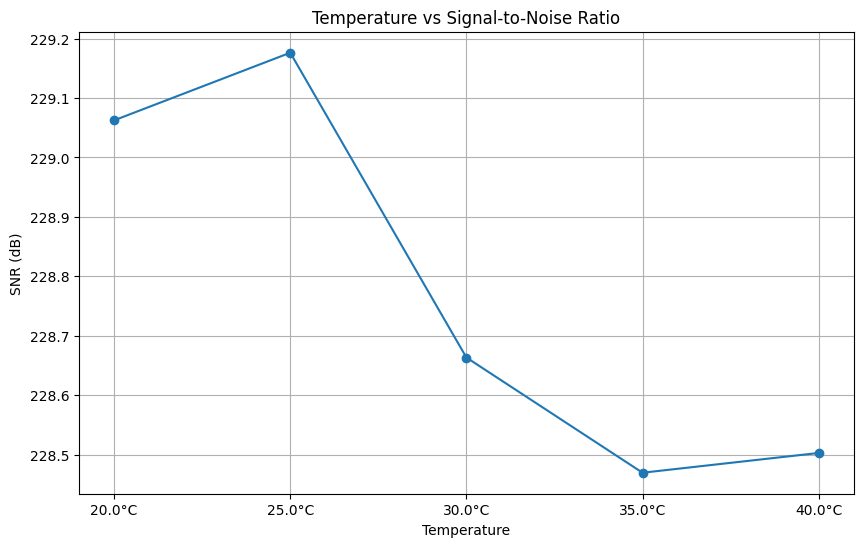

  Temperature 20.0°C: SNR = 229.06 dB
  Temperature 25.0°C: SNR = 229.18 dB
  Temperature 30.0°C: SNR = 228.66 dB
  Temperature 35.0°C: SNR = 228.47 dB
  Temperature 40.0°C: SNR = 228.50 dB

Simulation Complete! Blacklace Graphene Amplifier shows promising performance for BCI applications.


In [ ]:
# Example usage
if __name__ == "__main__":
    print("Blacklace Graphene Amplifier Simulation")
    print("---------------------------------------")

    # Create amplifier with default graphene properties
    amplifier = GrapheneAmplifier()

    # Show amplifier characteristics
    print(f"Electrode-Skin Impedance: {amplifier.contact_impedance:.2f} Ω")
    print(f"Theoretical Noise Floor: {amplifier.noise_floor * 1e6:.4f} μV")

    # Plot frequency response
    amplifier.plot_frequency_response()

    # Compare with other materials
    comparison = amplifier.compare_materials()
    print("\nMaterial Comparison:")
    for material, impedance in comparison['impedances'].items():
        print(f"  {material}: {impedance:.1f} Ω, SNR: {comparison['snrs'][material]:.2f} dB")

    # Simulate EEG acquisition (5 seconds) with all frequency bands
    print("\nSimulating EEG acquisition...")
    raw, amplified = amplifier.simulate_eeg_acquisition(5)

    # Plot results
    t = np.arange(0, 5, 1/500)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, raw)
    plt.title('Raw EEG Signal')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, amplified)
    plt.title('Blacklace Graphene Amplifier Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Analyze signal quality
    print("\nAnalyzing Signal Quality...")
    quality_metrics = amplifier.analyze_signal_quality(amplified)
    print(f"Signal-to-Noise Ratio: {quality_metrics['SNR']:.2f} dB")
    print(f"RMS Amplitude: {quality_metrics['RMS']:.2f} μV")
    print(f"Peak-to-Peak Amplitude: {quality_metrics['Peak-to-Peak']:.2f} μV")
    print("Frequency Band Powers:")
    for band, power in quality_metrics['Band Powers'].items():
        print(f"  {band}: {power:.2f} μV²/Hz")

    # Optimize parameters
    print("\nOptimizing Amplifier Parameters...")
    best_params, _ = amplifier.optimize_parameters()
    print(f"Optimal Parameters: Thickness = {best_params['thickness_nm']} nm, Area = {best_params['area_mm2']} mm²")

    # Create optimized amplifier
    print("\nCreating Optimized Amplifier...")
    optimized_amp = GrapheneAmplifier(**best_params)

    # Compare original vs optimized
    _, optimized_signal = optimized_amp.simulate_eeg_acquisition(5)

    # Plot comparison
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, amplified)
    plt.title('Original Amplifier Output')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, optimized_signal)
    plt.title('Optimized Amplifier Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Simulate temperature effects
    print("\nSimulating Temperature Effects...")
    temp_results = amplifier.simulate_temperature_effect(temp_range=(20, 40), steps=5)
    for temp, metrics in temp_results.items():
        print(f"  Temperature {temp}: SNR = {metrics['snr']:.2f} dB")

    print("\nSimulation Complete! Blacklace Graphene Amplifier shows promising performance for BCI applications.")